# **DEEP LEARNING-BASED VEIN SEGMENTATION**

---

This notebook, part of the project: [**Edge AI-Based Vein Detector for Efficient Venipuncture in the Antecubital Fossa**](https://doi.org/10.1007/978-3-031-47640-2_24), implements and compares four semantic segmentation architectures (U-Net, SegNet, PSPNet, and DeepLabv3+) for vein identification in near-infrared images from this [dataset](https://drive.google.com/file/d/1-6hCFfxxFFCx1fuBaQODVqDVOiWPl42U/view). Furthermore, a Pix2Pix implementation for vein segmentation is provided in a separate notebook in the same folder.  The primary goal is to identify the best-performing segmentation model and subsequently integrate an antecubital zone detector to allow physicians to focus on veins within that specific region.  TensorFlow was chosen because its TensorFlow Lite compression module is crucial for deployment on edge devices.

## 1. DATA LOADING

In [ ]:
# Standard libraries
import os
import pandas as pd
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import warnings
import random
from google.colab import drive, files

# Tensorflow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import load_img, img_to_array, plot_model
from tensorflow.keras import backend as K

# Metric and ML modules
from skimage.metrics import peak_signal_noise_ratio
from sklearn.metrics import jaccard_score, accuracy_score, f1_score
from scipy.spatial import distance
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Mount gdrive
DRIVE_HOME = "/content/gdrive"
drive.mount(DRIVE_HOME)

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.__version__)

!python --version

2.14.0
Python 3.10.12


In [ ]:
# Define here the path for experiments, where resulting models will be saved.
DATASET = "final" # Options: final (base version), augmented

# Define here the path of the dataset
GDRIVE_DATASET = f"square_{DATASET}_dataset512x512.zip"
GDRIVE_DATASET_PATH = os.path.join(DRIVE_HOME,"MyDrive/Datasets 📊/CUBITAL",GDRIVE_DATASET)

EXPERIMENTS_PATH = os.path.join(DRIVE_HOME,"MyDrive/ML Experiments 🧪/CUBITAL",DATASET)


LOCAL_DATASET_PATH = "/content/dataset"
if os.path.exists(LOCAL_DATASET_PATH):
  shutil.rmtree(LOCAL_DATASET_PATH)

# Download and sort the dataset
!unzip -qn "$GDRIVE_DATASET_PATH" -d "$LOCAL_DATASET_PATH" > /dev/null

for folder in glob(LOCAL_DATASET_PATH+"/*"):
  for in_folder in glob(folder+"/*"):
    file_name = in_folder.split("/")[4]
    shutil.move(in_folder,os.path.join(LOCAL_DATASET_PATH, file_name))

  shutil.rmtree(folder)

## 2. TENSORFLOW DATASET CREATION

In [ ]:
IMAGE_SIZE = 512 # options: 512, 256, 128
BATCH_SIZE = 8
NUM_CLASSES = 3

TOTAL_IMAGES = len(os.listdir(os.path.join(LOCAL_DATASET_PATH,"preprocessed_images")))

print("Total images:",TOTAL_IMAGES)

NUM_TRAIN_IMAGES = int(TOTAL_IMAGES * 0.70)
NUM_VAL_IMAGES = int(TOTAL_IMAGES * 0.20)
NUM_TEST_IMAGES = int(TOTAL_IMAGES * 0.10)

print("Number of train images:",NUM_TRAIN_IMAGES," val images:",NUM_VAL_IMAGES," test images:",NUM_TEST_IMAGES)

train_images = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "preprocessed_images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "masks/*")))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "preprocessed_images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "masks/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

test_images = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "preprocessed_images/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : ]
test_masks = sorted(glob(os.path.join(LOCAL_DATASET_PATH, "masks/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : ]

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, dtype=tf.int32)
  else:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 127.5 - 1
  return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Total images: 2016
Number of train images: 1411  val images: 403  test images: 201
Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.int32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.int32, name=None))>
Test Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.int32, name=None))>


## 3. MODEL DEVELOPMENT AND TRAINING

### **3.1 Unet**

#### 3.1.1 Define model

Implementation of Unet based on the [Keras'](https://keras.io/examples/vision/oxford_pets_image_segmentation/) implementation.

In [ ]:
def define_unet(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (1,))

  ### [First half of the network: downsampling inputs] ###

  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256, 512]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs] ###

  for filters in [512, 256, 128, 64, 32]:
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Add a per-pixel classification layer
  outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

keras.backend.clear_session()
unet = define_unet((IMAGE_SIZE,IMAGE_SIZE), NUM_CLASSES)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

#### 3.1.2 Train model

In [ ]:
unet.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

epochs = 10
history = unet.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/10
352/352 [==============================] - 48s 73ms/step - loss: 0.8099 - accuracy: 0.9292 - val_loss: 0.2933 - val_accuracy: 0.9526
Epoch 2/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0846 - accuracy: 0.9717 - val_loss: 0.1006 - val_accuracy: 0.9627
Epoch 3/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0519 - accuracy: 0.9818 - val_loss: 0.1007 - val_accuracy: 0.9634
Epoch 4/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0396 - accuracy: 0.9856 - val_loss: 0.0621 - val_accuracy: 0.9790
Epoch 5/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0350 - accuracy: 0.9878 - val_loss: 0.0506 - val_accuracy: 0.9821
Epoch 6/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.0283 - val_accuracy: 0.9896
Epoch 7/10
352/352 [==============================] - 25s 71ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.0323 - val_accuracy:

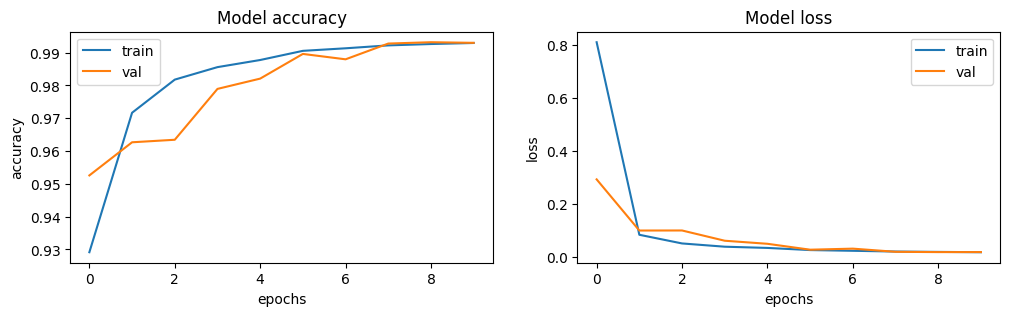

In [ ]:
def show_metrics(history):
  fig, ax = plt.subplots(1, 2, figsize=(12, 3))
  ax = ax.ravel()

  for i, metric in enumerate(["accuracy", "loss"]):
      ax[i].plot(history.history[metric])
      ax[i].plot(history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])

show_metrics(history)

#### 3.1.3 Test model

In [ ]:
def infer(model, image_tensor):
  '''
    Make inferences using a model and a new image. The latter requires to be in a Tensor format
  '''
  predictions = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  predictions = np.squeeze(predictions)
  predictions = np.argmax(predictions, axis=2)
  return predictions

def find_metrics(images_list, masks_list, model):
  '''
    This function gets metrics for a model according to the groundtruth
  '''
  ious = []
  dices = []
  psnrs = []
  accuracys = []
  f1scores = []

  for image_file, mask_file in tqdm(zip(images_list, masks_list),total=len(images_list)):
    # Read an image and its corresponding mask
    image_tensor = read_image(image_file)
    mask_tensor = read_image(mask_file, mask=True)
    # Make use of the model to predict a mask with a new image. Returns a numpy array.
    prediction_mask = infer(image_tensor=image_tensor, model=model)

    actual = np.squeeze(mask_tensor.numpy()).astype(np.uint8).flatten()
    predicted = prediction_mask.astype(np.uint8).flatten()

    ious.append(jaccard_score(actual, predicted, average="weighted"))
    dices.append(distance.dice(actual, predicted))
    psnrs.append(peak_signal_noise_ratio(actual, predicted))
    accuracys.append(accuracy_score(actual, predicted))
    f1scores.append(f1_score(actual, predicted, average="weighted"))

  return [np.mean(ious),
          np.mean(dices),
          np.mean(psnrs),
          np.mean(accuracys),
          np.mean(f1scores)]

# total_samples = 10
total_samples = len(test_images)
metrics = find_metrics(images_list=test_images[:total_samples], masks_list=test_masks[:total_samples], model=unet)
print("\n","IoU:",metrics[0],"Dice Score:",metrics[1],"PSNR:",metrics[2],"Accuracy:",metrics[3],"F1-Score:",metrics[4])

100%|██████████| 202/202 [00:36<00:00,  5.53it/s]


 IoU: 0.9873944995839866 Dice Score: 0.06341381337038848 PSNR: 70.43430280175858 Accuracy: 0.9932816382681969 F1-Score: 0.9924089477482245


#### 3.1.4 Save model

In [ ]:
def save_model(model, model_name):
  model_folder_path = os.path.join(EXPERIMENTS_PATH, model_name)
  if not os.path.exists(model_folder_path):
    os.mkdir(model_folder_path)
  model.save(os.path.join(model_folder_path,"best_model"))

save_model(unet, "unet")

### **3.4 SegNet**

#### 3.4.1 Define model

In [ ]:
from keras import backend as K
from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

def define_segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2)):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = layers.Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.Activation("relu")(conv_1)
    conv_2 = layers.Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_2 = layers.Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = layers.Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = layers.BatchNormalization()(conv_3)
    conv_3 = layers.Activation("relu")(conv_3)
    conv_4 = layers.Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = layers.BatchNormalization()(conv_4)
    conv_4 = layers.Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = layers.Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = layers.BatchNormalization()(conv_5)
    conv_5 = layers.Activation("relu")(conv_5)
    conv_6 = layers.Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = layers.BatchNormalization()(conv_6)
    conv_6 = layers.Activation("relu")(conv_6)
    conv_7 = layers.Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = layers.BatchNormalization()(conv_7)
    conv_7 = layers.Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = layers.Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = layers.BatchNormalization()(conv_8)
    conv_8 = layers.Activation("relu")(conv_8)
    conv_9 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = layers.BatchNormalization()(conv_9)
    conv_9 = layers.Activation("relu")(conv_9)
    conv_10 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = layers.BatchNormalization()(conv_10)
    conv_10 = layers.Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = layers.Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = layers.BatchNormalization()(conv_11)
    conv_11 = layers.Activation("relu")(conv_11)
    conv_12 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = layers.BatchNormalization()(conv_12)
    conv_12 = layers.Activation("relu")(conv_12)
    conv_13 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = layers.BatchNormalization()(conv_13)
    conv_13 = layers.Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build encoder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = layers.Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = layers.BatchNormalization()(conv_14)
    conv_14 = layers.Activation("relu")(conv_14)
    conv_15 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = layers.BatchNormalization()(conv_15)
    conv_15 = layers.Activation("relu")(conv_15)
    conv_16 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = layers.BatchNormalization()(conv_16)
    conv_16 = layers.Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = layers.Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = layers.BatchNormalization()(conv_17)
    conv_17 = layers.Activation("relu")(conv_17)
    conv_18 = layers.Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = layers.BatchNormalization()(conv_18)
    conv_18 = layers.Activation("relu")(conv_18)
    conv_19 = layers.Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = layers.BatchNormalization()(conv_19)
    conv_19 = layers.Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = layers.Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = layers.BatchNormalization()(conv_20)
    conv_20 = layers.Activation("relu")(conv_20)
    conv_21 = layers.Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = layers.BatchNormalization()(conv_21)
    conv_21 = layers.Activation("relu")(conv_21)
    conv_22 = layers.Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = layers.BatchNormalization()(conv_22)
    conv_22 = layers.Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = layers.Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = layers.BatchNormalization()(conv_23)
    conv_23 = layers.Activation("relu")(conv_23)
    conv_24 = layers.Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = layers.BatchNormalization()(conv_24)
    conv_24 = layers.Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = layers.Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = layers.BatchNormalization()(conv_25)
    conv_25 = layers.Activation("relu")(conv_25)

    outputs = layers.Convolution2D(n_labels, (1, 1), padding="valid", activation="softmax")(conv_25)
    # conv_26 = layers.BatchNormalization()(conv_26)
    # print()
    # conv_26 = layers.Reshape(
    #     (input_shape[0] * input_shape[1], n_labels),
    #     input_shape=(input_shape[0], input_shape[1], n_labels),
    # )(conv_26)

    # outputs = layers.Activation("softmax")(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

keras.backend.clear_session()
segnet = define_segnet((IMAGE_SIZE, IMAGE_SIZE, 1), NUM_CLASSES)

Build enceder done..
Build decoder done..


#### 3.4.2 Train model

In [ ]:
segnet.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

epochs = 10
history = segnet.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

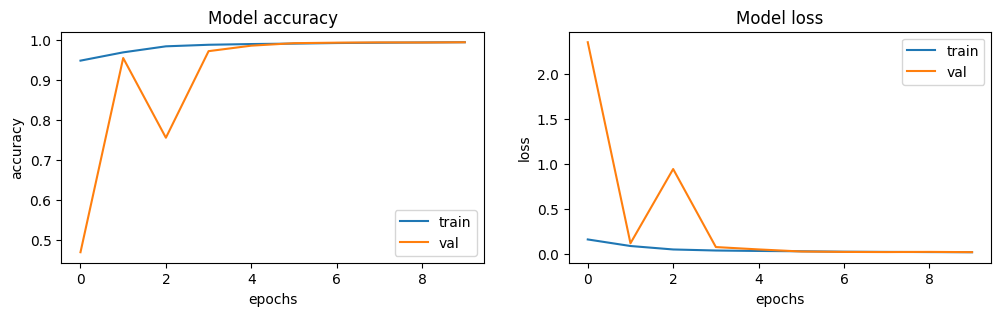

In [ ]:
def show_metrics(history):
  fig, ax = plt.subplots(1, 2, figsize=(12, 3))
  ax = ax.ravel()

  for i, metric in enumerate(["accuracy", "loss"]):
      ax[i].plot(history.history[metric])
      ax[i].plot(history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])

show_metrics(history)

#### 3.4.3 Evaluate model

In [ ]:
# total_samples = 10
total_samples = len(test_images)
metrics = find_metrics(images_list=test_images[:total_samples], masks_list=test_masks[:total_samples], model=segnet)
print("\n","IoU:",metrics[0],"Dice Score:",metrics[1],"PSNR:",metrics[2],"Accuracy:",metrics[3],"F1-Score:",metrics[4])

100%|██████████| 202/202 [00:47<00:00,  4.24it/s]


 IoU: 0.9865682000259525 Dice Score: 0.054791783059672486 PSNR: 70.0476825573838 Accuracy: 0.9926234519127572 F1-Score: 0.9922483876381653


#### 3.4.4 Save model

In [ ]:
segnet.save(EXPERIMENTS_PATH+"segnet/best_model")

### **3.5 PSPNet**



#### 3.5.1 Define model

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X

    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = layers.Convolution2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = layers.BatchNormalization(name=b+'batch_norm_a')(X)
    X = layers.LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = layers.Convolution2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
                      padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = layers.BatchNormalization(name=b+'batch_norm_b')(X)
    X = layers.LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = layers.Convolution2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
                      padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = layers.BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = layers.Convolution2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = layers.BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = layers.Add(name=b+'add')([X,X_skip])
    X = layers.ReLU(name=b+'relu')(X)
    return X

def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps

    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # block_2
    base = conv_block(base,[64,64,128],'2')
    # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module

    base = base_feature_maps(input_layer)
    # red
    red = layers.GlobalAveragePooling2D(name='red_pool')(base)
    red = layers.Reshape((1,1,256))(red)
    red = layers.Convolution2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = layers.UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    # yellow
    yellow = layers.AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = layers.Convolution2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = layers.UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    # blue
    blue = layers.AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = layers.Convolution2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = layers.UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    # green
    green = layers.AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = layers.Convolution2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = layers.UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    green = layers.BatchNormalization(name='last_conv_3_by_3_batch_norm')(green)
    # base + red + yellow + blue + green
    return layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    outputs = layers.Convolution2D(NUM_CLASSES, kernel_size=3, activation="softmax", padding='same',name='last_conv_3_by_3')(X)
    # X = layers.BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    # outputs = layers.Conv2D(NUM_CLASSES, 3, activation="softmax", padding="same")(X)
    # X = layers.Activation('sigmoid',name='last_conv_relu')(X)
    # X = layers.Flatten(name='last_conv_flatten')(X)
    return outputs

input_layer = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='input')
output_layer = last_conv_module(input_layer)
pspnet = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#### 3.5.2 Train model

In [ ]:
pspnet.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

epochs = 10
history = pspnet.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/10
352/352 [==============================] - 39s 83ms/step - loss: 0.1579 - accuracy: 0.9519 - val_loss: 0.1585 - val_accuracy: 0.9395
Epoch 2/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0931 - accuracy: 0.9667 - val_loss: 0.1052 - val_accuracy: 0.9682
Epoch 3/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0714 - accuracy: 0.9742 - val_loss: 0.1333 - val_accuracy: 0.9623
Epoch 4/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0608 - accuracy: 0.9780 - val_loss: 0.1040 - val_accuracy: 0.9699
Epoch 5/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0543 - accuracy: 0.9805 - val_loss: 0.0843 - val_accuracy: 0.9737
Epoch 6/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0498 - accuracy: 0.9820 - val_loss: 0.0831 - val_accuracy: 0.9749
Epoch 7/10
352/352 [==============================] - 27s 78ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.0683 - val_accuracy:

#### 3.5.3 Evaluate model

In [ ]:
# total_samples = 10
total_samples = len(test_images)
metrics = find_metrics(images_list=test_images[:total_samples], masks_list=test_masks[:total_samples], model=pspnet)
print("\n","IoU:",metrics[0],"Dice Score:",metrics[1],"PSNR:",metrics[2],"Accuracy:",metrics[3],"F1-Score:",metrics[4])

100%|██████████| 202/202 [00:19<00:00, 10.19it/s]



 IoU: 0.9478767115919862 Dice Score: 0.5158403479492489 PSNR: 63.592126914927334 Accuracy: 0.96932318659112 F1-Score: 0.9672274407588013


#### 3.5.4 Save model

In [ ]:
pspnet.save(EXPERIMENTS_PATH+"pspnet/best_model")

### **3.6 DeepLabv3+**

#### 3.6.1 Define model


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 1))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input, input_shape = (image_size,image_size,1)
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

deeplab = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
deeplab.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

#### 3.6.2 Train model

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
deeplab.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = deeplab.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

print("Training finished!")

Epoch 1/10
352/352 [==============================] - 57s 68ms/step - loss: 0.0948 - accuracy: 0.9658 - val_loss: 1.4022 - val_accuracy: 0.7061
Epoch 2/10
352/352 [==============================] - 22s 64ms/step - loss: 0.0595 - accuracy: 0.9792 - val_loss: 0.4452 - val_accuracy: 0.8484
Epoch 3/10
352/352 [==============================] - 22s 64ms/step - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.2117 - val_accuracy: 0.9357
Epoch 4/10
352/352 [==============================] - 22s 64ms/step - loss: 0.0318 - accuracy: 0.9886 - val_loss: 0.1154 - val_accuracy: 0.9604
Epoch 5/10
352/352 [==============================] - 22s 64ms/step - loss: 0.0272 - accuracy: 0.9902 - val_loss: 0.1069 - val_accuracy: 0.9646
Epoch 6/10
352/352 [==============================] - 22s 63ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.5173 - val_accuracy: 0.8553
Epoch 7/10
352/352 [==============================] - 22s 64ms/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.1469 - val_accuracy:

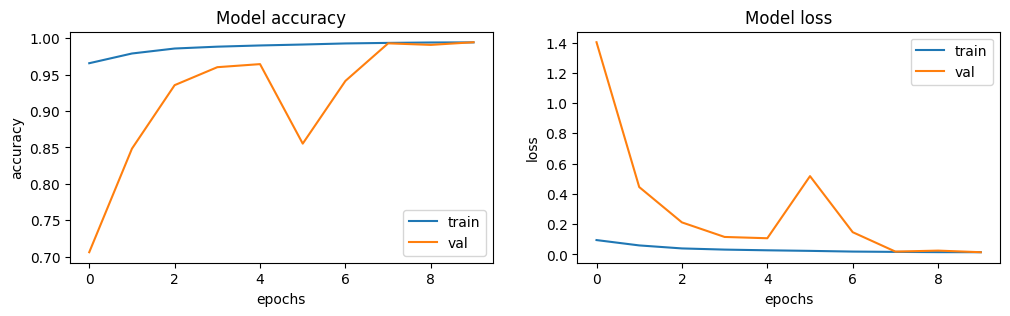

In [ ]:
show_metrics(history)

#### 3.6.3 Evaluate model

In [ ]:
# total_samples = 10
total_samples = len(test_images)
metrics = find_metrics(images_list=test_images[:total_samples], masks_list=test_masks[:total_samples], model=deeplab)
print("\n","IoU:",metrics[0],"Dice Score:",metrics[1],"PSNR:",metrics[2],"Accuracy:",metrics[3],"F1-Score:",metrics[4])

100%|██████████| 202/202 [00:35<00:00,  5.73it/s]


 IoU: 0.9805819675150785 Dice Score: 0.11992442084411198 PSNR: 68.62200458265136 Accuracy: 0.988507601294187 F1-Score: 0.9888506281033721


#### 3.6.4 Save model

In [ ]:
deeplab.save(EXPERIMENTS_PATH+"deeplab/best_model")

## 4. MODEL COMPRESSION

In [ ]:
for model, model_name in zip([pspnet],["pspnet"]):
  # Model compression with TFLite
  converter = tf.lite.TFLiteConverter.from_saved_model(EXPERIMENTS_PATH+model_name+"/best_model")
  converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                          tf.lite.OpsSet.SELECT_TF_OPS]

  try:
    tflite_model = converter.convert()
  except:
    print(model_name+" caused errors when compressing.")
  if not os.path.exists(EXPERIMENTS_PATH+model_name+"/compressed_model"):
    os.mkdir(EXPERIMENTS_PATH+model_name+"/compressed_model")
  open(EXPERIMENTS_PATH+model_name+"/compressed_model/model.tflite", "wb").write(tflite_model)